# **Install Dependencies**

In [ ]:
!pip install basemap
!pip install geopandas
!pip install contextily

# **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.cluster import DBSCAN
from mpl_toolkits.basemap import Basemap
import plotly.express as px
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.datasets import load_iris

# **Mount Google Drive**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# **Load Dataset**

In [ ]:
file_path = '/content/drive/My Drive/TBC.csv'
data = pd.read_csv(file_path, delimiter=';')

# View Dataset

In [ ]:
# Menampilkan dataset
print (data.head())

  tingkatan  tahun  longitude  latitude  pasien_baru_bakteriologis_paru  \
0      Nias   2023      97.52     1.127                           116.0   
1      Nias   2022      97.52     1.127                           132.0   
2      Nias   2021      97.52     1.127                            62.0   
3      Nias   2020      97.52     1.127                            68.0   
4      Nias   2019      97.52     1.127                           271.0   

   pasien_baru_klinis_paru  pasien_baru_ekstraparu  pasien_tidak_diketahui  \
0                     56.0                     2.0                     6.0   
1                    121.0                     3.0                    21.0   
2                     24.0                     0.0                     0.0   
3                    129.0                     3.0                     0.0   
4                      0.0                    22.0                     0.0   

   pasien_kambuh_bakteriologis_paru  pasien_kambuh_klinis_paru  \
0             

# **Analisis Data**

In [ ]:
# Display summary statistics for all columns in the DataFrame
print(data.describe())

            tahun   longitude    latitude  pasien_baru_bakteriologis_paru  \
count   264.00000  264.000000  264.000000                      264.000000   
mean   2019.50000   98.890606    2.313788                      431.007576   
std       2.29564    0.740313    0.921597                      602.179167   
min    2016.00000   97.420000    0.374000                       38.000000   
25%    2017.75000   98.450000    1.610000                      161.750000   
50%    2019.50000   98.970000    2.384000                      260.000000   
75%    2021.25000   99.440000    3.050000                      424.500000   
max    2023.00000  100.180000    3.867000                     3927.000000   

       pasien_baru_klinis_paru  pasien_baru_ekstraparu  \
count               264.000000              264.000000   
mean                327.621212               41.185606   
std                 631.497635              116.352518   
min                   0.000000                0.000000   
25%             

# **Preprocessing**

# Periksa Nilai Null & Hapus

In [ ]:
# Periksa nilai null pada dataset
print(data.isnull().sum())

# Haous baris mengandung nilai null
data_cleaned = data.dropna()

# Verifikasi baris-baris telah dihapus
print("Original rows:", len(data))
print("Rows after dropping nulls:", len(data_cleaned))

tingkatan                           0
tahun                               0
longitude                           0
latitude                            0
pasien_baru_bakteriologis_paru      0
pasien_baru_klinis_paru             0
pasien_baru_ekstraparu              0
pasien_tidak_diketahui              0
pasien_kambuh_bakteriologis_paru    0
pasien_kambuh_klinis_paru           0
pasien_kambuh_ekstraparu            0
pasien_diobati_selain_kambuh        0
dtype: int64
Original rows: 264
Rows after dropping nulls: 264


# Mencari nilai duplikat dan hapus

In [ ]:
# Periksa baris duplikat pada data
print("Number of duplicate rows:", data.duplicated().sum())

# Hapus baris-baris duplikat
data = data.drop_duplicates()

# Verifikasi baris-baris duplikat dihapus
print("Rows after removing duplicates:", len(data))

Number of duplicate rows: 0
Rows after removing duplicates: 264


# Search for outlier

In [ ]:
# Daftar kolom yang tidak diproses dalam penanganan outlier (pencilan)
exclude_columns = ['tingkatan', 'tahun', 'latitude', 'longitude']

# Iterasi setiap kolom selain pengecualian
for column in [col for col in data.columns if col not in exclude_columns]:
    # Hitung Q1 and Q3
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Batasan outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Hitung nilai median
    median_value = data[column].median()

    # Mengubah nilai outlier dengan nilai median
    data[column] = np.where((data[column] < lower_bound) | (data[column] > upper_bound), median_value, data[column])

    # Tampilkan nilai outlier yang ditangani untuk transparansi
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    print(f"Handled {len(outliers)} outliers in column '{column}'.")

# Verifikasi dataframe
print(data.head())

Handled 0 outliers in column 'pasien_baru_bakteriologis_paru'.
Handled 0 outliers in column 'pasien_baru_klinis_paru'.
Handled 0 outliers in column 'pasien_baru_ekstraparu'.
Handled 0 outliers in column 'pasien_tidak_diketahui'.
Handled 0 outliers in column 'pasien_kambuh_bakteriologis_paru'.
Handled 0 outliers in column 'pasien_kambuh_klinis_paru'.
Handled 0 outliers in column 'pasien_kambuh_ekstraparu'.
Handled 0 outliers in column 'pasien_diobati_selain_kambuh'.
  tingkatan  tahun  longitude  latitude  pasien_baru_bakteriologis_paru  \
0      Nias   2023      97.52     1.127                           116.0   
1      Nias   2022      97.52     1.127                           132.0   
2      Nias   2021      97.52     1.127                            62.0   
3      Nias   2020      97.52     1.127                            68.0   
4      Nias   2019      97.52     1.127                           271.0   

   pasien_baru_klinis_paru  pasien_baru_ekstraparu  pasien_tidak_diketahui  \
0

# Apply Transformation

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (264). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (264). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (264). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (264). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (264). 

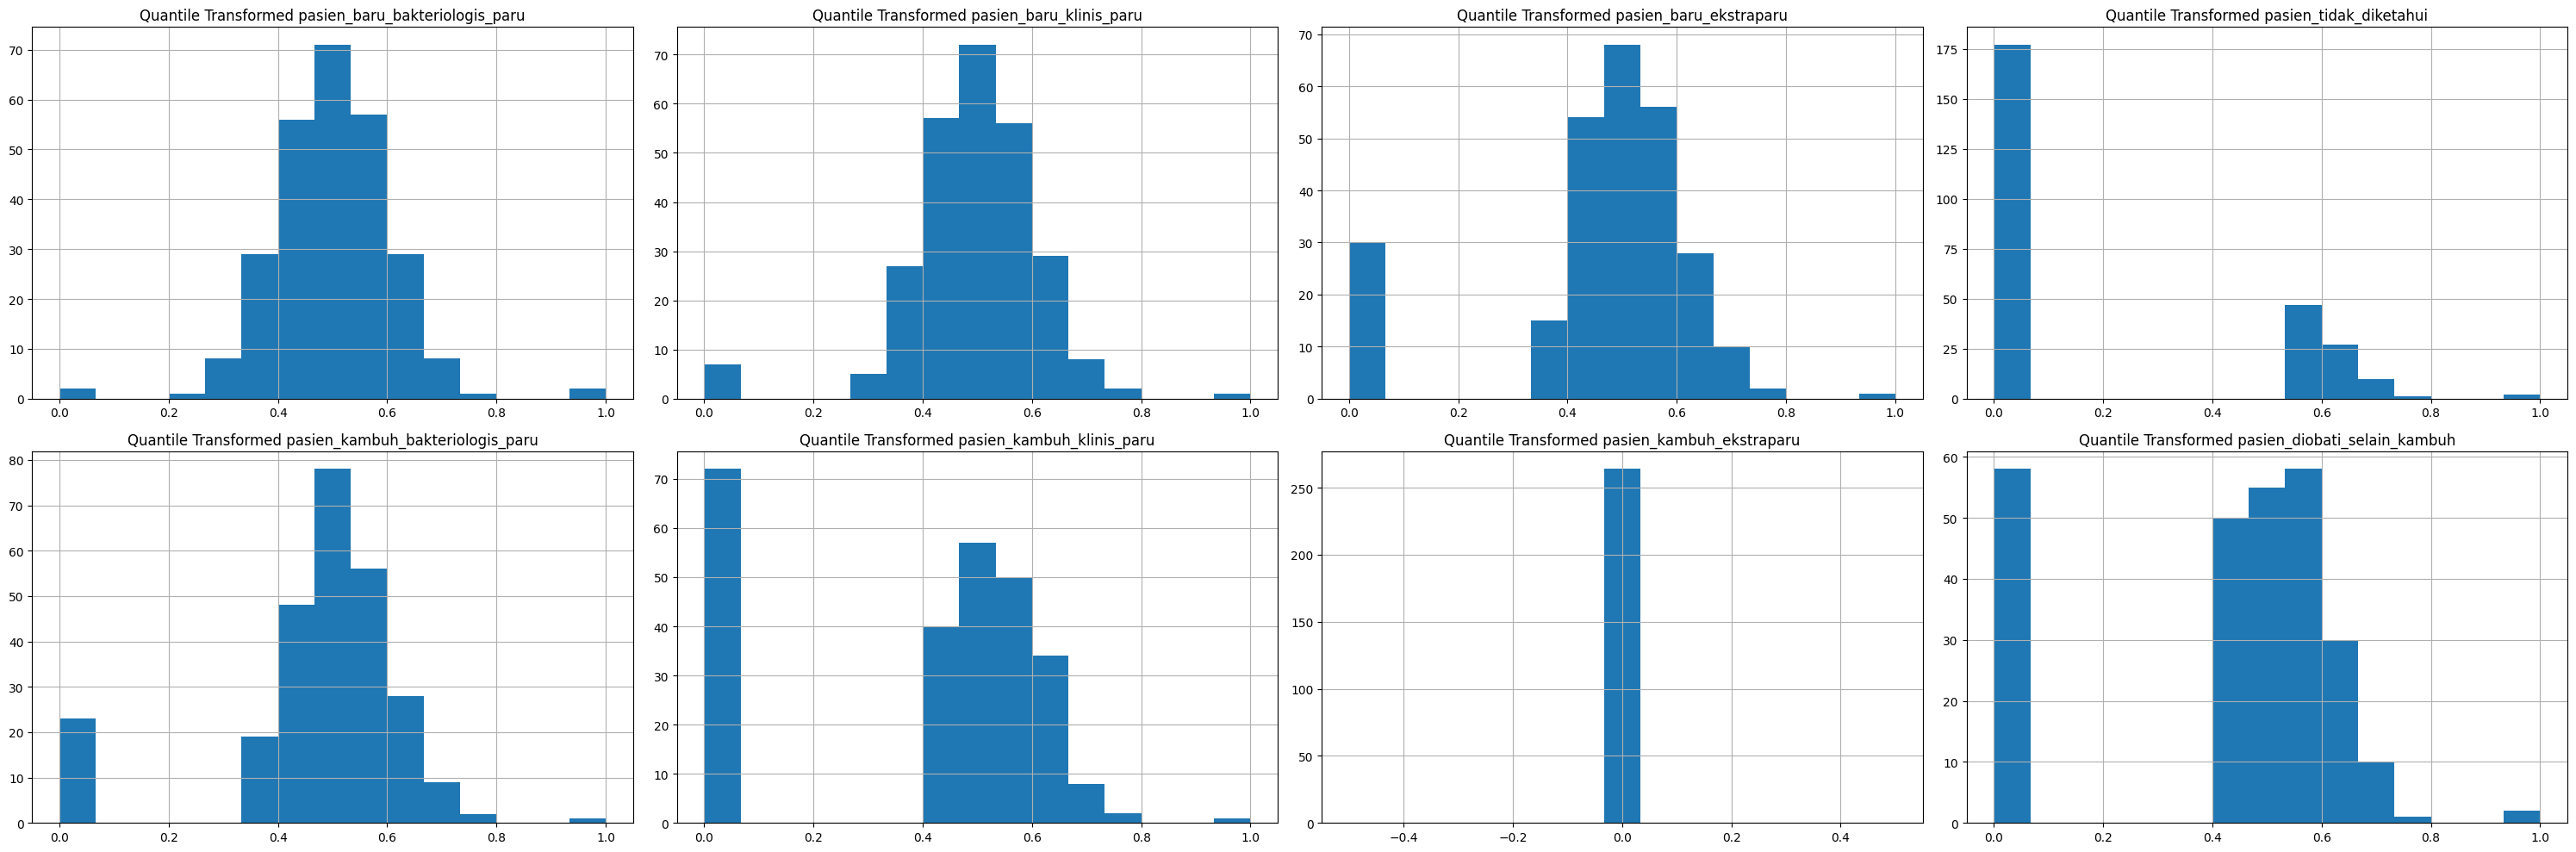

In [ ]:
# transformasi untuk setiap kolom pada 'data'
def apply_quantile_transformation(data: pd.DataFrame, columns_to_transform: list, output_distribution='normal', random_seed=42) -> pd.DataFrame:
    """Apply quantile transformation to the specified columns."""
    transformer = QuantileTransformer(output_distribution=output_distribution, random_state=random_seed)
    scaler = MinMaxScaler(feature_range=(0, 1))
    for col in columns_to_transform:
        transformed_data = transformer.fit_transform(data[[col]])
        scaled_data = scaler.fit_transform(transformed_data)
        data[f"{col}_quantile"] = scaled_data
    return data

# menampilkan histogram data yang sudah ditransformasi
def plot_transformed_data(data: pd.DataFrame, columns_to_transform: list, transformation_suffix='_quantile') -> None:
    """Plot histograms of the transformed data."""
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 10))
    for ax, col in zip(axes.flatten(), columns_to_transform):
        data[f"{col}{transformation_suffix}"].hist(ax=ax, bins=15)
        ax.set_title(f"Quantile Transformed {col}")
    fig.tight_layout()
    plt.show()

# daftar kolom yang ditransformasi (tipe pasien)
columns_to_transform = [
    "pasien_baru_bakteriologis_paru",
    "pasien_baru_klinis_paru",
    "pasien_baru_ekstraparu",
    "pasien_tidak_diketahui",
    "pasien_kambuh_bakteriologis_paru",
    "pasien_kambuh_klinis_paru",
    "pasien_kambuh_ekstraparu",
    "pasien_diobati_selain_kambuh",
]

# implementasi transformasi
data_transformed = apply_quantile_transformation(data, columns_to_transform)

# visualisasi plot data
plot_transformed_data(data_transformed, columns_to_transform)

In [ ]:
print(data_transformed.head())

  tingkatan  tahun  longitude  latitude  pasien_baru_bakteriologis_paru  \
0      Nias   2023      97.52     1.127                           116.0   
1      Nias   2022      97.52     1.127                           132.0   
2      Nias   2021      97.52     1.127                            62.0   
3      Nias   2020      97.52     1.127                            68.0   
4      Nias   2019      97.52     1.127                           271.0   

   pasien_baru_klinis_paru  pasien_baru_ekstraparu  pasien_tidak_diketahui  \
0                     56.0                     2.0                     6.0   
1                    121.0                     3.0                    21.0   
2                     24.0                     0.0                     0.0   
3                    129.0                     3.0                     0.0   
4                      0.0                    22.0                     0.0   

   pasien_kambuh_bakteriologis_paru  pasien_kambuh_klinis_paru  \
0             

# Apply PCA

In [ ]:
# PCA reduksi dimensi mempertahankan 95% varians data asli
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)  # X_scaled untuk versi data yang sudah diubah

# periksa jumlah komponen dipilih PCA
print(f"Number of PCA components: {pca.n_components_}")

# menampilkan keterangan dari fitur apa saja yang berkontribusi pada setiap komponen PCA
print("PCA Components:")
for i, component in enumerate(pca.components_):
    print(f"Component {i+1}:")
    print(f"Top features contributing to this component:")
    # Menampilkan indeks fitur dengan bobot terbesar untuk setiap komponen
    top_features = sorted(list(zip(X.columns, component)), key=lambda x: abs(x[1]), reverse=True)[:5]
    for feature, weight in top_features:
        print(f"{feature}: {weight:.3f}")
    print()

Number of PCA components: 2
PCA Components:
Component 1:
Top features contributing to this component:
pasien_baru_klinis_paru: 0.747
pasien_baru_bakteriologis_paru: 0.664
pasien_kambuh_bakteriologis_paru: 0.023
pasien_baru_ekstraparu: 0.018
pasien_diobati_selain_kambuh: 0.009

Component 2:
Top features contributing to this component:
pasien_baru_bakteriologis_paru: 0.747
pasien_baru_klinis_paru: -0.664
pasien_baru_ekstraparu: -0.010
pasien_kambuh_klinis_paru: -0.004
pasien_diobati_selain_kambuh: -0.003



# **Clustering**

In [ ]:
# konversi kolom kategori 'tingkatan' menjadi variabel dummy
data_transformed = pd.get_dummies(data_transformed, columns=['tingkatan'])

In [ ]:
# mendefinisikan kolom yang diubah dengan transformasi
transformed_columns = columns_to_transform  # kolom yang sudah ditransformasi
columns_for_clustering = transformed_columns + ['latitude', 'longitude']  # termasuk data geografis

# seluruh kolom relevan diekstrak untuk clustering
X = data_transformed[columns_for_clustering]

# menampilak baris pertama pada data untuk verifikasi
print(X.head())

   pasien_baru_bakteriologis_paru  pasien_baru_klinis_paru  \
0                           116.0                     56.0   
1                           132.0                    121.0   
2                            62.0                     24.0   
3                            68.0                    129.0   
4                           271.0                      0.0   

   pasien_baru_ekstraparu  pasien_tidak_diketahui  \
0                     2.0                     6.0   
1                     3.0                    21.0   
2                     0.0                     0.0   
3                     3.0                     0.0   
4                    22.0                     0.0   

   pasien_kambuh_bakteriologis_paru  pasien_kambuh_klinis_paru  \
0                               5.0                        1.0   
1                              16.0                        2.0   
2                               6.0                        4.0   
3                               3.0         

# Search for optimal epsilon

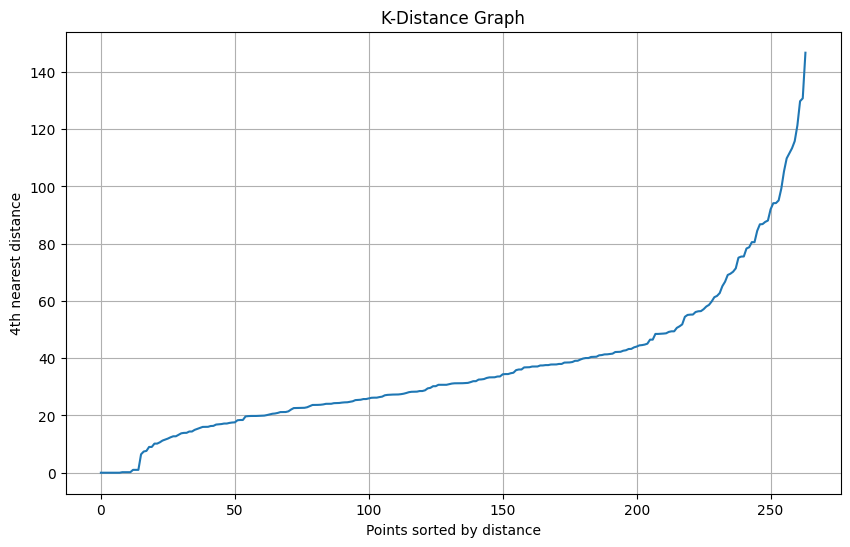

In [ ]:
# NearestNeighbors untuk mencari jarak k setiap titik
nbrs = NearestNeighbors(n_neighbors=4).fit(X)  # pakai k=4 sebagai contoh
distances, indices = nbrs.kneighbors(X)

# mengurutkan jarak
sorted_distances = np.sort(distances[:, 3], axis=0)  # k=4-1 karena index mulai dari 0

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('4th nearest distance')
plt.grid(True)
plt.show()

# Search for optimal minimum samples

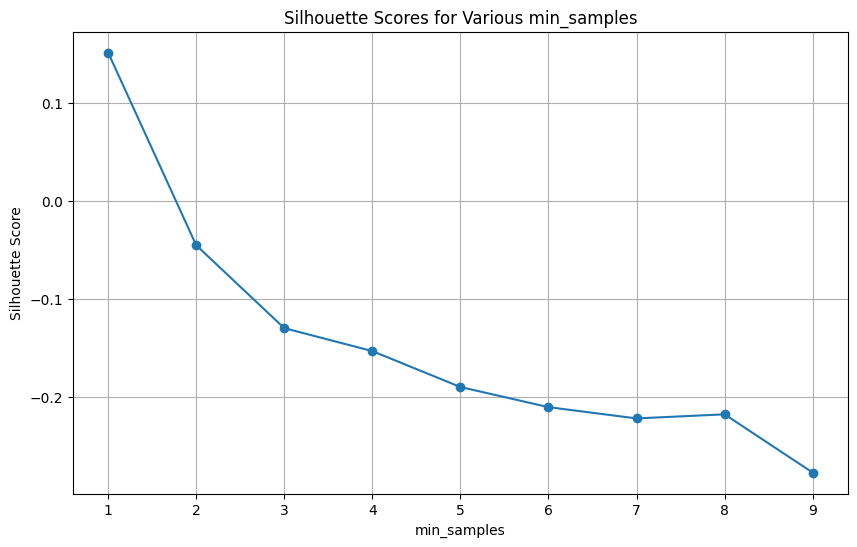

In [ ]:
eps_value = 20

# coba nilai min samples berbeda
min_samples_values = range(1, 10)  # contoh range
silhouette_scores = []

for min_samples in min_samples_values:
    db = DBSCAN(eps=eps_value, min_samples=min_samples)
    labels = db.fit_predict(X)
    if len(set(labels)) > 1:  # Silhouette score valid jika hanya terbentuk cluster
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1)  # indikasi tidak ada cluster

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(min_samples_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Various min_samples')
plt.xlabel('min_samples')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [ ]:
eps_value = 20
min_samples = 1

# DBSCAN clustering
db = DBSCAN(eps=eps_value, min_samples=min_samples)
labels = db.fit_predict(X)

# evaluasi cluster menggunakan silhoyette
if len(set(labels)) > 1:  # Silhouette score hanya valid ketika ada cluster
    silhouette_score_value = silhouette_score(X, labels)
    davies_bouldin_score_value = davies_bouldin_score(X, labels)
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # tidak termasuk noise jika ada
    print(f"Silhouette Score: {silhouette_score_value}")
    print(f"Davies-Bouldin Index: {davies_bouldin_score_value}")
    print(f"Number of clusters formed: {num_clusters}")

Silhouette Score: 0.15122798915619162
Davies-Bouldin Index: 0.26611200117343486
Number of clusters formed: 155


# DBSCAN Clustering With PCA

eps: 10, min_samples: 3, clusters: 12, silhouette score: -0.23615556982384925, davies-bouldin score: 1.2654525543155137
eps: 10, min_samples: 4, clusters: 6, silhouette score: -0.23639322819468034, davies-bouldin score: 1.5660231340852975
eps: 10, min_samples: 5, clusters: 4, silhouette score: -0.31415485050668257, davies-bouldin score: 2.5593649686295685
eps: 10, min_samples: 6, clusters: 1, silhouette score: -1, davies-bouldin score: -1
eps: 10, min_samples: 7, clusters: 1, silhouette score: -1, davies-bouldin score: -1
eps: 10, min_samples: 8, clusters: 1, silhouette score: -1, davies-bouldin score: -1
eps: 10, min_samples: 9, clusters: 1, silhouette score: -1, davies-bouldin score: -1
eps: 10, min_samples: 10, clusters: 1, silhouette score: -1, davies-bouldin score: -1
eps: 10, min_samples: 11, clusters: 1, silhouette score: -1, davies-bouldin score: -1
eps: 10, min_samples: 12, clusters: 1, silhouette score: -1, davies-bouldin score: -1
eps: 10, min_samples: 13, clusters: 1, silho

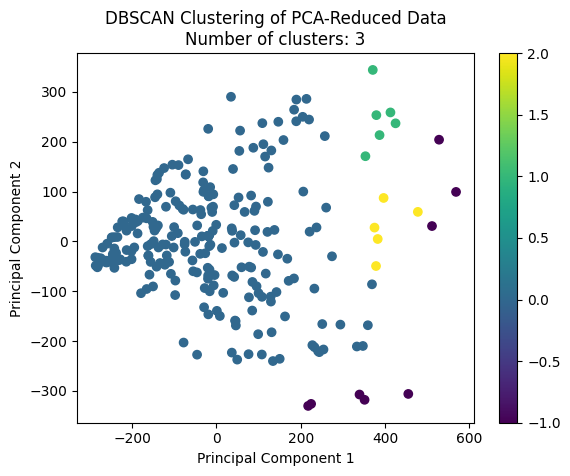

In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

# implementasi DBSCAN dan plot visualisasi
def apply_dbscan(X, eps, min_samples):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X)
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    silhouette_score_pca = silhouette_score(X, labels) if n_clusters > 1 else -1
    davies_bouldin_score_pca = davies_bouldin_score(X, labels) if n_clusters > 1 else -1
    return labels, n_clusters, silhouette_score_pca, davies_bouldin_score_pca

# Grid search untuk parameter optimal
best_silhouette = -1
best_davies_bouldin = float('inf')
best_eps = 0
best_min_samples = 0

for eps in np.arange(10, 100, 1):  # range dapat diatur sesuai kebutuhan
    for min_samples in range(3, 20):  # range dapat diatur sesuai kebutuhan
        labels, n_clusters, silhouette_score_pca, davies_bouldin_score_pca = apply_dbscan(X_pca, eps, min_samples)
        if n_clusters == 3 and silhouette_score_pca > best_silhouette:
            best_silhouette = silhouette_score_pca
            best_davies_bouldin = davies_bouldin_score_pca
            best_eps = eps
            best_min_samples = min_samples
        print(f"eps: {eps}, min_samples: {min_samples}, clusters: {n_clusters}, silhouette score: {silhouette_score_pca}, davies-bouldin score: {davies_bouldin_score_pca}")

print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}")
print(f"Best Silhouette Score: {best_silhouette}")
print(f"Best Davies-Bouldin Score: {best_davies_bouldin}")

# parameter terbaik
labels, n_clusters, silhouette_score_pca, davies_bouldin_score_pca = apply_dbscan(X_pca, best_eps, best_min_samples)

print(f"Final eps: {best_eps}, min_samples: {best_min_samples}")
print(f"Number of clusters: {n_clusters}")
print(f"Silhouette Score after PCA: {silhouette_score_pca}")
print(f"Davies-Bouldin Score after PCA: {davies_bouldin_score_pca}")

# opsional, menampilkan visualisasi
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o')
plt.title(f'DBSCAN Clustering of PCA-Reduced Data\nNumber of clusters: {n_clusters}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

# Map Visualization

In [ ]:
# Drop kolom yang tidak relevan
data_preprocessed = data.drop(columns=['longitude', 'latitude', 'tingkatan', 'tahun'])

# Lakukan PCA pada data
pca = PCA(n_components=2)
pca_features = pca.fit_transform(data_preprocessed)

# Mendapatkan loading matrix
loadings = pca.components_

# Mendapatkan nama-nama atribut asli
attributes = data_preprocessed.columns

# Menampilkan kontribusi atribut asli pada komponen utama
loading_matrix = pd.DataFrame(loadings.T, columns=['PC1', 'PC2'], index=attributes)

print("Loading matrix (kontribusi atribut asli pada komponen utama):")
print(loading_matrix)

Loading matrix (kontribusi atribut asli pada komponen utama):
                                                PC1       PC2
pasien_baru_bakteriologis_paru             0.664140  0.747422
pasien_baru_klinis_paru                    0.746983 -0.664257
pasien_baru_ekstraparu                     0.017982 -0.009617
pasien_tidak_diketahui                     0.001140  0.001532
pasien_kambuh_bakteriologis_paru           0.022599  0.000652
pasien_kambuh_klinis_paru                  0.004810 -0.004298
pasien_kambuh_ekstraparu                   0.000000  0.000000
pasien_diobati_selain_kambuh               0.008633 -0.003060
pasien_baru_bakteriologis_paru_quantile    0.000462  0.000463
pasien_baru_klinis_paru_quantile           0.000504 -0.000402
pasien_baru_ekstraparu_quantile            0.000361 -0.000127
pasien_tidak_diketahui_quantile           -0.000128 -0.000076
pasien_kambuh_bakteriologis_paru_quantile  0.000421  0.000012
pasien_kambuh_klinis_paru_quantile         0.000509 -0.000537
pasien_k

Initial number of clusters: 3
               Tingkatan Cluster Labels
0                 Asahan       -1, 0, 2
1              Batu Bara              0
2                 Binjai              0
3                  Dairi              0
4           Deli Serdang              0
5          Gunung Sitoli              0
6     Humbang Hasundutan              0
7                   Karo          0, -1
8           Labuhan Batu              0
9   Labuhan Batu Selatan              0
10    Labuhan Batu Utara              0
11               Langkat    2, 0, -1, 1
12      Mandailing Natal        1, 2, 0
13                 Medan              0
14                  Nias              0
15            Nias Barat              0
16          Nias Selatan              0
17            Nias Utara              0
18          Padang Lawas              0
19    Padang Lawas Utara              0
20      Padang Sidimpuan              0
21         Pak Pak Barat              0
22      Pematang Siantar              0
23        

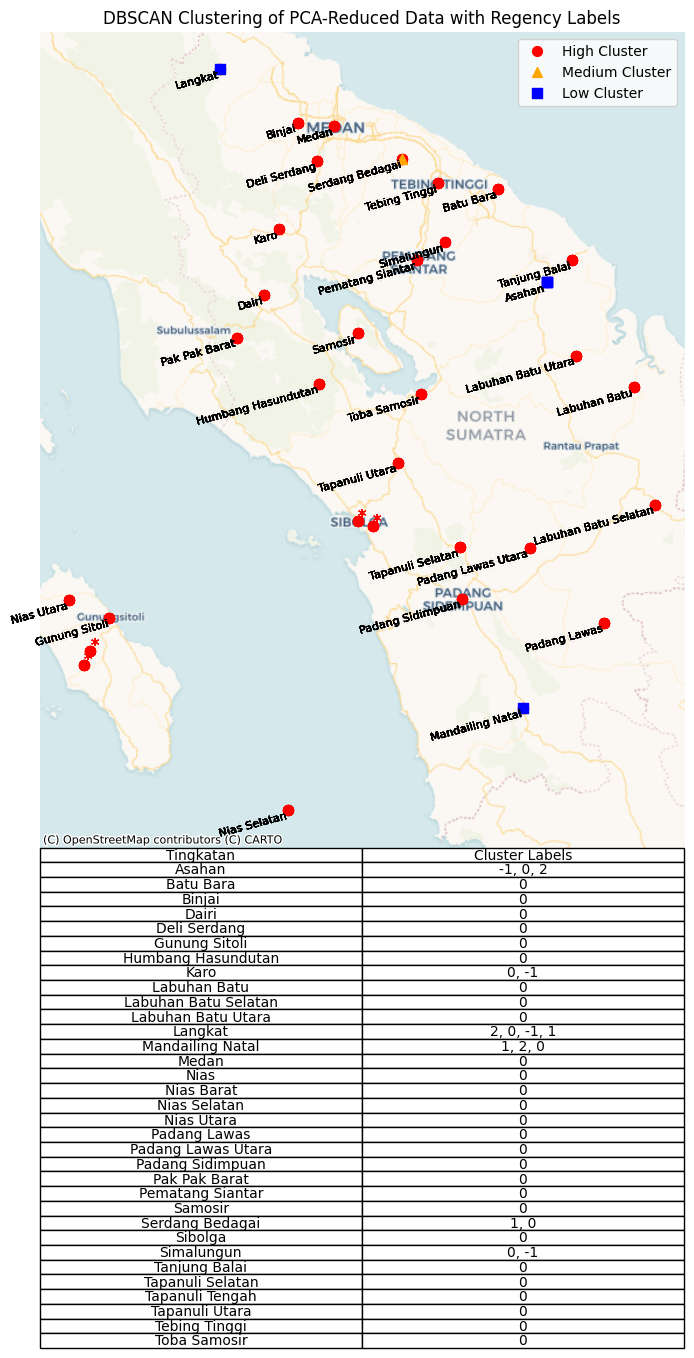

Cluster 0 ranges:
Minimum values: [-287.36927178 -240.21994137]
Maximum values: [368.82194234 290.10251233]
Mean values: [-30.74167875  -1.43460443]
Standard Deviation values: [150.69434023 108.55008894]

Cluster 1 ranges:
Minimum values: [353.27190074 170.82858906]
Maximum values: [424.72561219 343.98179784]
Mean values: [387.88348126 246.12660732]
Standard Deviation values: [24.29172455 52.63883933]

Cluster 2 ranges:
Minimum values: [374.84184737 -49.51401855]
Maximum values: [477.62158667  87.05246568]
Mean values: [401.94459008  25.79336625]
Standard Deviation values: [38.53935689 46.86931643]

Cluster criteria:
Cluster 0 criteria:
Minimum values: [-287.36927178 -240.21994137]
Maximum values: [368.82194234 290.10251233]

Cluster 1 criteria:
Minimum values: [353.27190074 170.82858906]
Maximum values: [424.72561219 343.98179784]

Cluster 2 criteria:
Minimum values: [374.84184737 -49.51401855]
Maximum values: [477.62158667  87.05246568]

Example point assigned to cluster: 0


In [ ]:
# PCA untuk reduksi dimensi
pca = PCA(n_components=2)
pca_features = pca.fit_transform(data.drop(columns=['longitude', 'latitude', 'tingkatan', 'tahun']))

# epsilon dan min samples terbaik
eps = 96
min_samples = 5

# DBSCAN cluster
db = DBSCAN(eps=eps, min_samples=min_samples).fit(pca_features)
labels = db.labels_

# memeriksa jumlah cluster
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f'Initial number of clusters: {num_clusters}')

# atur parameter secara bertahap untuk mendapatkan 3 cluster
while num_clusters != 3:
    if num_clusters > 3:
        eps *= 0.9  # kurangi nilai epsilon ketika terlalu banyak cluster
    else:
        eps *= 1.1  # tingkatkan nilai epsilon ketika jumlah cluster sedikit

    db = DBSCAN(eps=eps, min_samples=min_samples).fit(pca_features)
    labels = db.labels_
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f'Tuned eps: {eps}, Number of clusters: {num_clusters}')

# GeoDataFrame untuk plot
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))
gdf['cluster_labels'] = labels

# koordinat
gdf.set_crs('epsg:4326', inplace=True)
gdf = gdf.to_crs(epsg=3857)  # Project to Web Mercator for visualization purposes

# Penjelasan tinggi, sedang, dan rendah
cluster_labels = gdf['cluster_labels'].unique()
high_cluster = gdf[gdf['cluster_labels'] == cluster_labels[0]]
medium_cluster = gdf[gdf['cluster_labels'] == cluster_labels[1]]
low_cluster = gdf[gdf['cluster_labels'] == cluster_labels[2] if len(cluster_labels) > 2 else gdf['cluster_labels'] == -1]

# Visualisasi plot dalam bentuk maps
fig, ax = plt.subplots(1, 1, figsize=(20, 12))

# Membuat cluster beda warna
high_cluster.plot(ax=ax, markersize=50, color='red', marker='o', label='High Cluster')
medium_cluster.plot(ax=ax, markersize=50, color='orange', marker='^', label='Medium Cluster')
low_cluster.plot(ax=ax, markersize=50, color='blue', marker='s', label='Low Cluster')

# Jarak optimal untuk teks pada maps
coords = np.column_stack((gdf.geometry.x, gdf.geometry.y))
distances = euclidean_distances(coords, coords)
min_dist = np.percentile(distances[distances > 0], 1)

# Buat nama tingkatan
for idx, row in gdf.iterrows():
    if distances[idx][distances[idx] > 0].min() > min_dist / 2:
        ax.text(row.geometry.x, row.geometry.y, row['tingkatan'], fontsize=8, ha='right', va='top', rotation=15)
    else:
        ax.text(row.geometry.x, row.geometry.y, '*', fontsize=12, color='red')

# Buat map
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)
ax.set_title('DBSCAN Clustering of PCA-Reduced Data with Regency Labels')
ax.set_axis_off()

# Membuat tabel untuk cluster
table_data = gdf.groupby('tingkatan')['cluster_labels'].apply(lambda x: ', '.join(map(str, x.unique()))).reset_index()
table_data.columns = ['Tingkatan', 'Cluster Labels']

# Menampilkan table
print(table_data)

# Buat tabel data untuk plot
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')

# Atur tabel dan plot
plt.subplots_adjust(left=0.2, bottom=0.2)

# Menambahkan keterangan pada cluster
plt.legend()

plt.show()

# Analisis rentang nilai antara cluster
cluster_ranges = {}
for label in set(labels):
    if label != -1:  # Kecuali noise
        cluster_data = pca_features[labels == label]
        min_vals = cluster_data.min(axis=0)
        max_vals = cluster_data.max(axis=0)
        mean_vals = cluster_data.mean(axis=0)
        std_vals = cluster_data.std(axis=0)
        cluster_ranges[label] = {
            'min': min_vals,
            'max': max_vals,
            'mean': mean_vals,
            'std': std_vals
        }

# Tampilkan rentang nilai
for label, range_vals in cluster_ranges.items():
    print(f'Cluster {label} ranges:')
    print(f'Minimum values: {range_vals["min"]}')
    print(f'Maximum values: {range_vals["max"]}')
    print(f'Mean values: {range_vals["mean"]}')
    print(f'Standard Deviation values: {range_vals["std"]}\n')

# Tentukan kriteria untuk masuk ke setiap cluster
criteria = {}
for label, range_vals in cluster_ranges.items():
    criteria[label] = {
        'min': range_vals['min'],
        'max': range_vals['max']
    }

print("Cluster criteria:")
for label, crit in criteria.items():
    print(f'Cluster {label} criteria:')
    print(f'Minimum values: {crit["min"]}')
    print(f'Maximum values: {crit["max"]}\n')

# Menentukan apakah suatu daerah termasuk dalam cluster tertentu
def determine_cluster(pca_point, criteria):
    for label, crit in criteria.items():
        if np.all(pca_point >= crit['min']) and np.all(pca_point <= crit['max']):
            return label
    return -1  # Jika tidak sesuai dengan cluster manapun

# Contoh penggunaan fungsi untuk menentukan cluster suatu titik PCA
example_point = pca_features[0]
assigned_cluster = determine_cluster(example_point, criteria)
print(f'Example point assigned to cluster: {assigned_cluster}')
